# Do not change imports

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse.linalg import svds

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics.pairwise import cosine_similarity

from urllib.parse import urljoin
import itertools
import random

import matplotlib.pyplot as plt
%matplotlib inline

# A. MovieLens 100K Dataset: EDA via Pandas
TODO: Read the README (https://grouplens.org/datasets/movielens/100k/)

In [2]:
ML_100k_BASE_URL = 'http://files.grouplens.org/datasets/movielens/ml-100k/'

def movielens_url(fname):
    return urljoin(ML_100k_BASE_URL, fname)

## A.1. Read Genres

In [3]:
# names of the columns - see README, u.genre
genre_cols = ['genre', 'genre_id']

genres = pd.read_csv(movielens_url('u.genre'), sep='|', names=genre_cols)

genres

,genre,genre_id
0,unknown,0
1,Action,1
2,Adventure,2
3,Animation,3
4,Children's,4
5,Comedy,5
6,Crime,6
7,Documentary,7
8,Drama,8
9,Fantasy,9


## A.2. Read Users

In [4]:
user_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']

# TODO: read users from u.user
users = pd.read_csv(movielens_url('u.user'), sep='|', names=user_cols)

users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 5 columns):
user_id       943 non-null int64
age           943 non-null int64
sex           943 non-null object
occupation    943 non-null object
zip_code      943 non-null object
dtypes: int64(2), object(3)
memory usage: 36.9+ KB


## A.3. Read Movies

In [5]:
# Be lazy - let the genre table tell you the last set of column names
movie_cols = ['movie_id','movie_title','release_date','video_release_date','IMDb_URL'] + [g for g in genres.sort_values(by='genre_id')['genre']]

# TODO: read movies from u.item
movies = pd.read_csv(movielens_url('u.item'), sep='|', names=movie_cols, encoding = 'ISO-8859-1')

movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 24 columns):
movie_id              1682 non-null int64
movie_title           1682 non-null object
release_date          1681 non-null object
video_release_date    0 non-null float64
IMDb_URL              1679 non-null object
unknown               1682 non-null int64
Action                1682 non-null int64
Adventure             1682 non-null int64
Animation             1682 non-null int64
Children's            1682 non-null int64
Comedy                1682 non-null int64
Crime                 1682 non-null int64
Documentary           1682 non-null int64
Drama                 1682 non-null int64
Fantasy               1682 non-null int64
Film-Noir             1682 non-null int64
Horror                1682 non-null int64
Musical               1682 non-null int64
Mystery               1682 non-null int64
Romance               1682 non-null int64
Sci-Fi                1682 non-null int64
Thriller 

In [6]:
# TODO: Interesting... find the row with a null release_date!
movies[pd.isnull(movies['release_date'])]

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
266,267,unknown,NaN,NaN,NaN,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# TODO: assign movie_id (to check/clean up ratings later)
bad_row_id = 267
#movies.loc[movies['movie_id'] == 267].movie_id

# drop the row (in place!)
movies.drop(movies.loc[pd.isnull(movies.release_date)].index, inplace=True)

# TODO: confirm it's gone
movies[pd.isnull(movies['release_date'])]

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western


In [8]:
# TODO: output a table including only the movies with null IMDB urls
movies[pd.isnull(movies.IMDb_URL)]

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
1357,1358,The Deadly Cure (1996),16-Sep-1996,NaN,NaN,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1358,1359,Boys in Venice (1996),24-Sep-1996,NaN,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# output all the fields of the first row
movies.loc[1357]

movie_id                                1358
movie_title           The Deadly Cure (1996)
release_date                     16-Sep-1996
video_release_date                       NaN
IMDb_URL                                 NaN
unknown                                    0
Action                                     1
Adventure                                  0
Animation                                  0
Children's                                 0
Comedy                                     0
Crime                                      0
Documentary                                0
Drama                                      0
Fantasy                                    0
Film-Noir                                  0
Horror                                     0
Musical                                    0
Mystery                                    0
Romance                                    0
Sci-Fi                                     0
Thriller                                   0
War       

TODO: Try finding this movie with Google (it does exist) - what is special/different about it?

The Deadly Cure: http://www.imdb.com/title/tt0645145/ (found from http://movie-rs.com/the-deadly-cure-1996/). It looks to be a part of a series.

In [10]:
# TODO: output all the fields of the second row
movies.loc[1358]

movie_id                               1359
movie_title           Boys in Venice (1996)
release_date                    24-Sep-1996
video_release_date                      NaN
IMDb_URL                                NaN
unknown                                   0
Action                                    0
Adventure                                 0
Animation                                 0
Children's                                0
Comedy                                    0
Crime                                     0
Documentary                               0
Drama                                     1
Fantasy                                   0
Film-Noir                                 0
Horror                                    0
Musical                                   0
Mystery                                   0
Romance                                   0
Sci-Fi                                    0
Thriller                                  0
War                             

TODO: Try finding this movie with Google - comment on the likely name/origin of this movie

Can't seem to find "Boys in Venice". It is most likely "The Boys of Venice"?

In [11]:
# TODO: there is one movie with an unknown genre - what is it?
# movie: Good Morning (1971)
movies.loc[movies['unknown'] == 1]

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
1372,1373,Good Morning (1971),4-Feb-1971,NaN,http://us.imdb.com/M/title-exact?Good%20Mornin...,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


TODO: find this movie using Google - what is special about it? what would you indicate as its genre?

It looks to be a short film. Most likely a comedy

In [12]:
# TODO: there is a field of the movies dataset that has no useful values - what is it?
#movies[pd.notnull(movies.video_release_date)]
bad_field = 'video_release_date'
movies.drop(bad_field, 1, inplace=True)

# It also turns out that the IMDB url's don't work :(
movies.drop('IMDb_URL', 1, inplace=True)

movies.head()

,movie_id,movie_title,release_date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


## A.4. Read Ratings

In [31]:
rating_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']

# TODO: read ratings from u.data
ratings = pd.read_csv(movielens_url('u.data'), sep='\t', names=rating_cols)

ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
user_id           100000 non-null int64
movie_id          100000 non-null int64
rating            100000 non-null int64
unix_timestamp    100000 non-null int64
dtypes: int64(4)
memory usage: 3.1 MB


In [34]:
ratings.loc[ratings['movie_id'] == bad_row_id]

,user_id,movie_id,rating,unix_timestamp
2172,130,267,5,875801239
3781,5,267,4,875635064
7245,268,267,3,875742077
12475,297,267,3,875409139
14756,319,267,4,875707690
15292,1,267,4,875692955
49295,532,267,3,875441348
93523,833,267,1,875655669
99723,422,267,4,875655986


In [39]:
# TODO: remember to drop ratings of our bad movie above
ratings.drop(ratings[ratings.movie_id == bad_row_id].index, inplace=True)

# TODO: confirm they are gone
ratings.loc[ratings['movie_id'] == bad_row_id]

,user_id,movie_id,rating,unix_timestamp


## A.5. Merge Dataset

In [40]:
lens = pd.merge(pd.merge(movies, ratings), users)
lens.head()

,movie_id,movie_title,release_date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,...,Thriller,War,Western,user_id,rating,unix_timestamp,age,sex,occupation,zip_code
0,1,Toy Story (1995),01-Jan-1995,0,0,0,1,1,1,0,...,0,0,0,308,4,887736532,60,M,retired,95076
1,4,Get Shorty (1995),01-Jan-1995,0,1,0,0,0,1,0,...,0,0,0,308,5,887737890,60,M,retired,95076
2,5,Copycat (1995),01-Jan-1995,0,0,0,0,0,0,1,...,1,0,0,308,4,887739608,60,M,retired,95076
3,7,Twelve Monkeys (1995),01-Jan-1995,0,0,0,0,0,0,0,...,0,0,0,308,4,887738847,60,M,retired,95076
4,8,Babe (1995),01-Jan-1995,0,0,0,0,1,1,0,...,0,0,0,308,5,887736696,60,M,retired,95076


## A.6. Ask Interesting Questions

In [45]:
# TODO: compute sparsity = 100% * (# ratings) / ((# users) * (# movies))
#       basically: what percentage of the full utility matrix is represented?
s = 1.0 * (len(ratings.index)) / ((len(users.index)) * (len(movies.index)))
print('Sparsity:', '{:.2%}'.format(s))

Sparsity: 6.31%


In [48]:
# TODO: Aggregate by movie_id, get stats on number (i.e. size) of ratings per movie
ratings_per_movie = lens.groupby('movie_id').size()
ratings_per_movie.describe()

count    1681.000000
mean       59.483046
std        80.398338
min         1.000000
25%         6.000000
50%        27.000000
75%        80.000000
max       583.000000
dtype: float64

(array([  1.17034738e-02,   2.54512226e-03,   1.42077106e-03,
          6.84832093e-04,   3.88412232e-04,   2.45312989e-04,
          7.15496217e-05,   5.11068726e-05,   6.13282472e-05,
          1.02213745e-05]),
 array([   1. ,   59.2,  117.4,  175.6,  233.8,  292. ,  350.2,  408.4,
         466.6,  524.8,  583. ]),
 <a list of 10 Patch objects>)

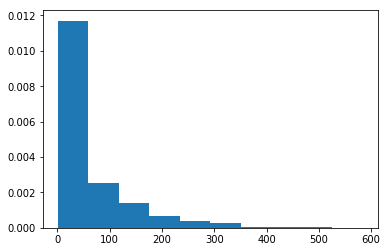

In [51]:
# TODO: Visualize the movie counts as a histogram
plt.hist(ratings_per_movie, normed=True, bins=10)

In [52]:
# TODO: Aggregate by user_id, get stats on number (i.e. size) of ratings per user
ratings_per_user = lens.groupby('user_id').size()
ratings_per_user.describe()

count    943.000000
mean     106.034995
std      100.920992
min       20.000000
25%       33.000000
50%       65.000000
75%      148.000000
max      737.000000
dtype: float64

(array([  8.28241864e-03,   2.70657609e-03,   1.41984320e-03,
          8.13451831e-04,   3.69750832e-04,   2.21850499e-04,
          7.39501665e-05,   1.47900333e-05,   1.47900333e-05,
          2.95800666e-05]),
 array([  20. ,   91.7,  163.4,  235.1,  306.8,  378.5,  450.2,  521.9,
         593.6,  665.3,  737. ]),
 <a list of 10 Patch objects>)

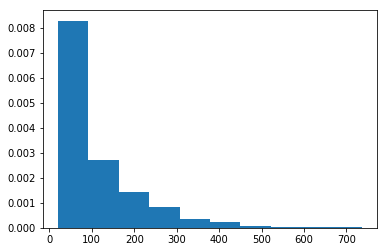

In [53]:
# TODO: Visualize the user counts as a histogram
plt.hist(ratings_per_user, normed=True, bins=10)

TODO: comment on the last two stats tables/plots - what does this say in general about ratings per user/movie?

There seems to be a higher average of ratings per user in comparison to ratings per movie.

In [77]:
# TODO: Which movie has the most ratings?
#d = lens.groupby('movie_id').size().sort_values(ascending=False)
#d.iloc[0]
#d.head(1)
movies.loc[movies['movie_id'] == 50]

,movie_id,movie_title,release_date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
49,50,Star Wars (1977),01-Jan-1977,0,1,1,0,0,0,0,...,0,0,0,0,0,1,1,0,1,0


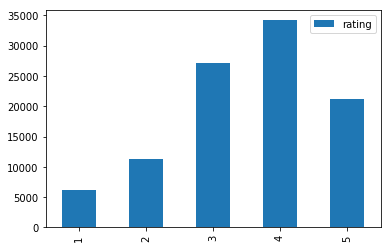

In [106]:
# TODO: are all ratings equally likely? output a bar chart of rating frequency overall
a = lens['rating'].value_counts().to_frame()
#sortedV = a.sort_values(by=['rating'])
a.sort_index().plot.bar()

In [101]:
# TODO: of the movies that have 100 or more ratings, what are the top-ten ranked movies?
#d =ratings_per_movie.index[ratings_per_movie > 100]
#d[:10]

In [89]:
# TODO: describe one more interesting question, and then query the result with Pandas

# B. Extract Utility Matrix

In [78]:
def user_id_to_index(id):
    return id-1

def user_index_to_id(idx):
    return idx+1

# Accounts for the bad movie
def movie_id_to_index(id):
    return id-1 if id<bad_row_id else id-2

# Accounts for the bad movie
def movie_index_to_id(idx):
    return idx+1 if idx<(bad_row_id-1) else idx+2

In [79]:
num_users = ratings.user_id.unique().shape[0]
num_movies = ratings.movie_id.unique().shape[0]

utility = np.zeros((num_users, num_movies))

for idx,rating in ratings.iterrows():
    utility[user_id_to_index(rating.user_id), movie_id_to_index(rating.movie_id)] = rating.rating

# should match above!
sparsity = float(len(utility.nonzero()[0]))
sparsity /= (utility.shape[0] * utility.shape[1])
sparsity *= 100
print('Sparsity: {:.2f}%'.format(sparsity))

Sparsity: 6.31%


# C. Evaluation via Mean Squared Error (MSE)

In [102]:
a = [1, 2, 3, 4, 5]
b = [1, 1, 4, 2, 10]
print("{:.4f}".format(mse(a, b)))

6.2000


TODO: Show the mathematical operations that reproduce the above result

$$ mse = \ldots $$

In [103]:
def mse_utility(u1, u2):
    return mse(u1[u1.nonzero()].flatten(), u2[u2.nonzero()].flatten())

u1 = np.array([[2, 0, 0, 4, 4], [5, 5, 5, 3, 3], [2, 4, 2, 1, 2]])
u2 = np.array([[3, 0, 0, 4, 4], [5, 5, 5, 3, 3], [2, 4, 2, 1, 7]])

print("{:.4f}".format(mse_utility(u1, u2)))

2.0000


TODO: 
1. Explain what operation is being performed. Include *why* it is appropriate in the context evaluating a recommender system, as well as performance implications.

2. Show the mathematical operations that reproduce the above result

$$ mse = \ldots $$

# D. Similarity via Cosine Distance

In [118]:
# TODO: implement, only use primitive Python loops/operations
#       sim = (A . B) / ( ||A|| ||B|| )
import math
def cosine_sim(v1, v2):
    sumxx, sumxy, sumyy = 0, 0, 0
    for i in range(len(v1)):
        x = v1[i]; y = v2[i]
        sumxx += x*x
        sumyy += y*y
        sumxy += x*y
    return sumxy/math.sqrt(sumxx*sumyy)
    
v1 = [5, 0, 3, 0, 2, 0, 0, 2, 0, 0]
v2 = [3, 0, 2, 0, 1, 1, 0, 1, 0, 1]

print("Cosine Similarity: {:.6f}, expected={:.6f}".format(cosine_sim(v1, v2), cosine_similarity(np.array(v1).reshape(1, -1), np.array(v2).reshape(1, -1))[0][0]))

Cosine Similarity: 0.935601, expected=0.935601


In [119]:
def sim_matrix(u, eps=1.0e-9):
    step1 = u.dot(u.T) + eps
    step2 = np.array([np.sqrt(np.diagonal(step1))])
    return (step1 / step2 / step2.T)

print(sim_matrix(u1))
print(cosine_sim(u1[0], u1[1]))
print(cosine_sim(u1[0], u1[2]))
print(cosine_sim(u1[1], u1[2]))

[[ 1.          0.58760596  0.49518757]
 [ 0.58760596  1.          0.94352977]
 [ 0.49518757  0.94352977  1.        ]]
0.587605960347
0.495187568472
0.943529768569


In [120]:
def sim_allpairs(u):
    n = u.shape[0]
    sim = np.eye(n)
    for x in itertools.combinations(range(n), 2):
        s = cosine_sim(u[x[0]], u[x[1]])
        sim[x[0], x[1]] = s
        sim[x[1], x[0]] = s
    
    return sim

print("MSE for U1: {:.4f}".format(mse_utility(sim_matrix(u1), sim_allpairs(u1))))
print("MSE for U2: {:.4f}".format(mse_utility(sim_matrix(u2), sim_allpairs(u2))))

MSE for U1: 0.0000
MSE for U2: 0.0000


In [121]:
%timeit -n 10 -r 3 sim_matrix(utility[:50,:])

180 µs ± 117 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [122]:
%timeit -n 10 -r 3 sim_allpairs(utility[:50,:])

888 ms ± 19.1 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


TODO:
1. Explain what each line of sim_matrix is doing (including why eps is necessary)
2. Explain why this approach is preferable to pairwise calls to cosine_sim (reference the previous two timeit calls; explain what each is doing and how it relates to your conclusion)

In [123]:
def sim_users(u):
    return sim_matrix(u)

# TODO: use sim_matrix to return similarity between items (i.e. movies)
def sim_items(u):
    return None

print(sim_items(u1))
print(cosine_sim(u1[:, 0], u1[:, 1]))
print(cosine_sim(u1[:, 0], u1[:, 2]))
print(cosine_sim(u1[:, 0], u1[:, 3]))
print(cosine_sim(u1[:, 0], u1[:, 4]))
print(cosine_sim(u1[:, 1], u1[:, 2]))
print(cosine_sim(u1[:, 1], u1[:, 3]))
print(cosine_sim(u1[:, 1], u1[:, 4]))
print(cosine_sim(u1[:, 2], u1[:, 3]))
print(cosine_sim(u1[:, 2], u1[:, 4]))
print(cosine_sim(u1[:, 3], u1[:, 4]))

None
0.897149958915
0.937436866561
0.853485927499
0.872786048178
0.957024404433
0.58193569724
0.667017009151
0.61910348462
0.655172413793
0.983282004984


# E. K-Neighborhood

In [124]:
# TODO: given a slice from a similarity matrix (arr),
#       index of "self" (self_idx),
#       and k
#       return dictionary of k most similar indexes as {idx:sim}
#       HINT: look at np.argsort
def top_k(arr, self_idx, k):
    return {}

In [ ]:
sim_u1 = sim_items(u1)

# Example via u1...
print(sim_u1)
print()

# Top-2 w.r.t. row 0 (should be {1: 0.897, 2:0.937})
print(sim_u1[0])
print(top_k(sim_u1[0], 0, 2))
print()

# Top-2 w.r.t. row 1 (should be {0: 0.897, 2:0.957})
print(sim_u1[1])
print(top_k(sim_u1[1], 1, 2))
print()

# Top-3 w.r.t. col 1 (should be {0: 0.897, 2:0.957, 4:0.667})
print(sim_u1[:, 1])
print(top_k(sim_u1[:, 1], 1, 3))
print()

# F. Recommend via Similar Users

In [ ]:
# TODO: given utility matrix (m_utility),
#       similarity of users (m_sim_users),
#       user index of interest (user_idx),
#       item index of interest (item_idx),
#       neighborhood size (k)
# 
#       output the average of the similarity-weighted ratings
#       of top-k similar users that have
#       rated the item
def rec_via_users(m_utility, m_sim_users, user_idx, item_idx, k):
    return 0
    
print(u1)
print()
print(sim_users(u1))
print()

# Expected: 5
print(rec_via_users(u1, sim_users(u1), 0, 1, 1))

# Expected: 4.54 ~ (.588 * 5) + (.495 * 4) / (.588 + .495)
print(rec_via_users(u1, sim_users(u1), 0, 1, 2))

## F.1. Evaluation

In [ ]:
random.seed(12345)

def recs_via_users(m_utility, m_sim_users, k, test_n):
    test = random.sample(range(m_sim_users.shape[0]), test_n)
    true = []
    pred = []
    for user_idx in test:
        for item_idx in range(m_utility.shape[1]):
            if m_utility[user_idx][item_idx] != 0:
                true.append(m_utility[user_idx][item_idx])
                
                p = round(rec_via_users(m_utility, m_sim_users, user_idx, item_idx, k))
                if p != 0:    
                    pred.append(p)
                else:
                    pred.append(1.0e-9)
                        

    return mse_utility(np.array([true], dtype=np.float64), np.array([pred], dtype=np.float64))
    
similarity_users = sim_users(utility)

ks = []
mses = []
for i in range(50):
    ks.append(i+1)
    mses.append(recs_via_users(utility, similarity_users, i+1, 100))
    print("{}/50".format(i+1), mses[-1])

In [ ]:
%timeit -n 10 -r 3 recs_via_users(utility, similarity_users, 2, 100)

In [ ]:
%timeit -n 10 -r 3 recs_via_users(utility, similarity_users, 20, 100)

In [ ]:
plt.plot(ks, mses)

TODO:
1. Describe what is being done in the recs_via_users function - what is the evaluation approach? What would have been a more "fair" methodology?
2. What do you notice happening as k increases?
3. Based upon these results, what is a reasonable neighborhood size?

# G. Recommend via SVD

In [ ]:
random.seed(12345)

# TODO: given a utility matrix and
#       number of singular values to use
# 
#       return a projected matrix
#       based upon a limited number of dimensions
#       U_pred = U S V^T
# 
#       HINT: the svds function does most of the work for you
def svd_projection(m_utility, num_dims):
    return None

def recs_via_svd(m_utility, num_dims, test_n):
    test = random.sample(range(m_utility.shape[0]), test_n)    
    svd_utility = svd_projection(utility, num_dims)
    
    true = []
    pred = []
    for user_idx in test:
        for item_idx in range(m_utility.shape[1]):
            if m_utility[user_idx][item_idx] != 0:
                true.append(m_utility[user_idx][item_idx])
                p = round(svd_utility[user_idx][item_idx])
                
                if p != 0:
                    pred.append(p)
                else:
                    pred.append(1.0e-9)

    return mse_utility(np.array([true], dtype=np.float64), np.array([pred], dtype=np.float64))
    
    
ds = []
mses = []
for i in range(100):
    ds.append(i+1)
    mses.append(recs_via_svd(utility, i+1, 100))
    print("{}/100".format(i+1), mses[-1])

In [ ]:
%timeit -n 10 -r 3 recs_via_svd(utility, 10, 100)

In [ ]:
%timeit -n 10 -r 3 recs_via_svd(utility, 20, 100)

In [ ]:
%timeit -n 10 -r 3 recs_via_svd(utility, 40, 100)

In [ ]:
%timeit -n 10 -r 3 recs_via_svd(utility, 80, 100)

In [ ]:
plt.plot(ds, mses)

TODO: comment on the relative speed/quality of the SVD approach as compared to the neighborhood approach

# H. TODO: Your Turn
The previous sections explored some building blocks and methods of recommendation for the MovieLens dataset.
In this section, you must extend this work:
1. Implement a method that was not covered above (e.g. item-based neighborhood, direct matrix factorization) OR extend a method (e.g. incorporate rating bias)
2. Evaluate your method similar to what was done above

Do NOT change any code above - only add code/comment in this section (as many cells as you see fit). You are welcome to copy-paste code from above.

# I. Extra Credit
If you so choose, create an actual recommendation engine using one of the supplied methods:
1. Create a function that takes as input a dictionary of {movie_title:rating}, as well as a k, and your function should return the top k movies that have not been watched and have highest predicted ratings.
2. Run the function on a few representative examples - analyze your results.